In [530]:
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import sys
from skimage.metrics import structural_similarity as ssim
from multiprocessing import Pool, Process, Manager
import time
import itertools
import operator
import pickle as pk
from skimage import filters

np.random.seed(482)

In [2]:
PATH='./Data/'

In [3]:
np.set_printoptions(threshold=1000)

In [211]:
_neighbors = [(-1, 0), (0, -1), (1, 0), (0, 1)]
def _getSamplingProbabilities(_grid, _bias, _weight, _height, _width):
    prob = np.zeros((_height, _width))
    indices = np.indices(_grid.shape)
    _neighbors_grid = []
    for _direction_id in range(4):
        neighbors_dir = indices.copy()
        neighbors_dir[0, 1:-1, 1:-1] = neighbors_dir[0, 1:-1, 1:-1] + _neighbors[_direction_id][0]
        neighbors_dir[1, 1:-1, 1:-1] = neighbors_dir[1, 1:-1, 1:-1] + _neighbors[_direction_id][1]
        _grid_dir = _grid[(neighbors_dir[0], neighbors_dir[1])]
        _neighbors_grid.append(_grid_dir)
    _neighbors_grid = np.array(_neighbors_grid)

    # _neighbors_grid = np.array([_gridU, _gridL, _gridD, _gridR])
    prob = _bias + np.sum(_weight*_neighbors_grid, axis=0)
    prob = sigma(2*prob)
    return prob

def sigma(a):
    return 1/(1 + np.exp(-a))

_neighbors = [(-1, 0), (0, -1), (1, 0), (0, 1)]
def getSamplingProbabilities(_grid, _bias, _weight, _width, _height):
    prob = np.zeros((_height, _width))
    for y in range(1, 31):
        for x in range(1, 31): #in zip(range(1,31), range(1,31)):
            neighbors = [tuple(map(lambda a, b: a + b, (x, y), n)) for n in _neighbors]
            neighbor_vector = np.array([_grid[t] for t in neighbors])
            prob[x-1, y-1] = sigma(2*_bias + 2*np.sum(_weight*neighbor_vector, axis=0))
    return prob

def GibbsSampling(_grid, _Niters, _bias, _weights, _Height, _Width):
    """
    Run Niterations of gibbs sampling and generation _Niters samples
    _Niters: number of iterations to run gibbs sampling for
    _bias: Bias parameters of model
    _weights: weights for dependence on neighbors
    _Height: height of MDP grid
    _Width: width of MDP grid
    Returns a _Niters length list containing sampling generated using GibbsSampling
    """
    samples = []
    gridP= np.pad(_grid, 1)
    for t in range(N):
        r = np.random.uniform(0, 1, _Width*_Height)
        r = np.reshape(r, (_Width, _Height)).T

        prob = _getSamplingProbabilities(gridP, np.pad(_bias, 1),  _weights, _Height, _Width)

        gridn = np.ones((_Height, _Width)) 
        gridn[np.where(r > prob[1:-1, 1:-1])] = -1
        gridn = np.pad(gridn, 1)
        gridP = gridn
        samples.append(gridn[1:-1, 1:-1])
    
    return samples

In [217]:
###### Gibbs Sampling Update Within each iteration ########
_neighbors = [(-1, 0), (0, -1), (1, 0), (0, 1)]
def getSamplingProbAt(_grid, _bias, _weight, _width, _height, y, x):
    """
    Get Probability at x, y
    """
#     neighbors = [tuple(map(lambda a, b: a + b, (y, x), n)) for n in _neighbors]
#     neighbor_vector = np.array([_grid[t] for t in neighbors])
    neighbor_vector = np.array([_grid[tuple(map(operator.add, (y,x), t))] for t in _neighbors])
    prob = sigma(2*_bias + 2*np.sum(_weight*neighbor_vector))
    
    return prob

def GibbsSampling2(_grid, _Niters, _bias, _weights, _Height, _Width):
    """
    Run Niterations of gibbs sampling and generation _Niters samples
    _Niters: number of iterations to run gibbs sampling for
    _bias: Bias parameters of model
    _weights: weights for dependence on neighbors
    _Height: height of MDP grid
    _Width: width of MDP grid
    Returns a _Niters length list containing sampling generated using GibbsSampling
    """
    samples = []
    gridP= np.pad(_grid, 1)
    yx_tuples = [t for t in itertools.product(range(1, _Height+1), range(1, _Width+1))]
    for t in range(_Niters):
        r = np.random.uniform(0, 1, _Width*_Height)
        r = np.reshape(r, (_Height, _Width))
        for (y, x) in yx_tuples:
            prob = getSamplingProbAt(gridP, _bias[y-1, x-1],  _weights, _Height, _Width, y, x)
            if (r[y-1, x-1] > prob):
                gridP[y, x] = -1
            else:
                gridP[y, x] = 1
        samples.append(gridP[1:-1, 1:-1].copy())
    
    return samples

## Q3. Run Gibbs Sampling for weights in {0.0, 0.1, 0.2, 0.3, 0.4, 0.5}

In [212]:
np.random.seed(482)
N = 100
Height = 30
Width = 30
grid = np.ones((Height, Width))
bias = np.zeros((Height, Width))

samplesVSweights = {}
for weightsIter in range(0, 6):
    weights = weightsIter/10
    samplesVSweights[weights] = GibbsSampling2(grid, N, bias, weights, Height, Width)

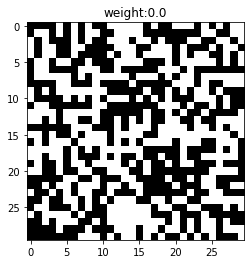

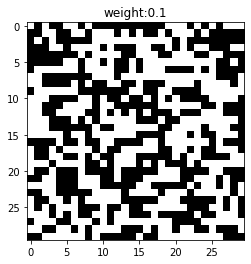

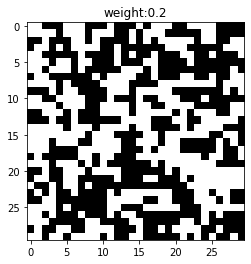

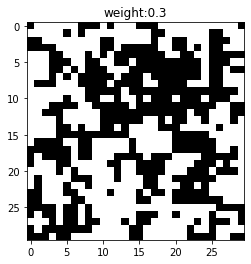

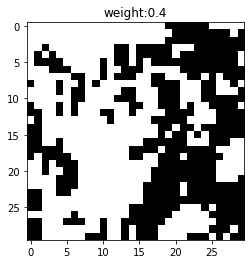

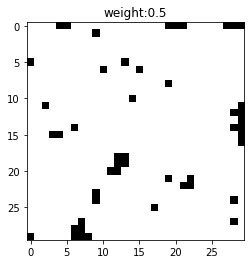

In [213]:
# print(samplesVSweights[0.1])
for i in range(6):
    img = Image.fromarray((samplesVSweights[i/10][-1][1:-1, 1:-1] + 1)/2*255)
    plt.title("weight:{}".format(i/10))
    plt.imshow(img)
    plt.savefig("figures/q3_Samples_{}_gibbs2.png".format(i/10))
    plt.show()

## Q5: Mixing Times

In [265]:
def SamplesVSweights(grid, bias, weight, samplesVSweights_results_ph, MixingIters=1):
    Height, Width = grid.shape
    mixingtimeSamples = []
    for mIter in range(MixingIters):
        mixingtimeSamples.append(GibbsSampling2(grid, N, bias, weight, Height, Width))
    samplesVSweights_results_ph[weight] = np.array(mixingtimeSamples)
    return mixingtimeSamples

In [266]:
###### Run 5 Processes parallely to compute Expected performance #######
np.random.seed(482)
MixingIters = 100

grid = np.ones((30, 30))

N = 100
Height = 30
Width = 30
bias = np.zeros((Height, Width))

samplesVSweights_results_ph = Manager().dict()
q5_args_list = []
for weightsIter in range(0, 6):
    weights = weightsIter/10
    q5_args_list.append((grid.copy(), bias, weights, samplesVSweights_results_ph, MixingIters))

q5_jobs = []

start = time.time()
for i in range(len(q5_args_list)):
    p = Process(target=SamplesVSweights, args=q5_args_list[i])
    q5_jobs.append(p)
    p.start()
    
for proc in q5_jobs:
    proc.join()
    
end = time.time()
print("Time: ", end - start)

Time:  184.64661812782288


In [267]:
samplesVSweights_results_ph.keys()

[0.4, 0.0, 0.2, 0.3, 0.1, 0.5]

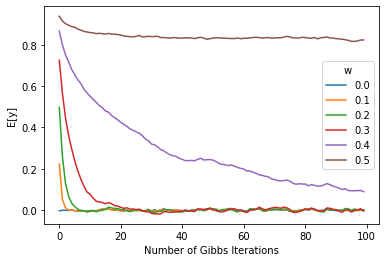

In [268]:
for _weights in range(0, 6):
    _weights_key = _weights/10
    ms = np.array(samplesVSweights_results_ph[_weights_key])
    msreshaped = np.reshape(ms, (MixingIters, N, ms.shape[-2]*ms.shape[-1]))
    msmean = np.mean(msreshaped, axis=2)
    msmeanmean = np.mean(msmean, axis=0)
    # plt.plot(msmeanmean)
    plt.xlabel('Number of Gibbs Iterations')
    plt.ylabel('E[y]')
    plt.plot(msmeanmean, label='_weights_key')
#     plt.errorbar(range(1,101), msmeanmean, yerr=np.var(msmean, axis=0), ecolor='orange')
    
plt.legend([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], title="w")
    
plt.savefig('figures/mixingTimes_w.png'.format(_weights_key))
plt.show()

## Q7. Fixed Parameter Denoising 

### Declare utility functions: Compute error metrics, Normalize a given image to {-1,+1}

In [204]:
def normalize(img):
    imgc = img.copy()
    imgc = imgc/255*2 - 1
    return imgc
    
def _mae_error(img1, img2):
    diffimg = img1 - img2
    diffimgabs = np.abs(diffimg)
    return np.sum(diffimgabs)/(img1.shape[0]*img1.shape[1])

def _mse_error(img1, img2):
    diffimg = img1 - img2
    diffimgsq = diffimg*diffimg
    return np.sqrt(np.sum(diffimgsq))/(img1.shape[0]*img1.shape[1])

def error(img1, img2, errtype='mse'):
    if (errtype == 'mse'):
        err = _mse_error(img1, img2)
    elif (errtype == 'mae'):
        err = _mae_error(img1, img2)
    elif (errtype == 'ssim'):
        err = -ssim(img1, img2, data_range=2)
    return err 

# error(noisy_image_np, clean_image_np)
print(error(normalize(noisy_image_np), normalize(clean_image_np), errtype='mse'))
print(error(normalize(noisy_image_np), normalize(clean_image_np), errtype='mae'))
print(error(noisy_image_np, clean_image_np, errtype='ssim'))

0.006952905211158743
0.7444805194805195
-0.04000595287061396


Noisy Image:


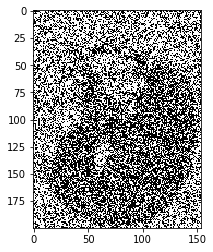

Clean Image:


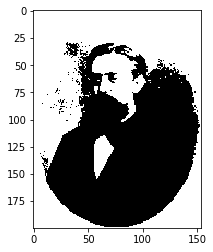

In [369]:
###### Read and display the given Noisy and Clean Images ########
noisy_image = Image.open('Data/im_noisy.png')
clean_image = Image.open('Data/im_clean.png')

noisy_image_np = np.array(noisy_image)
print("Noisy Image:")
plt.imshow(noisy_image_np, cmap='gray')
plt.show()

clean_image_np = np.array(clean_image)
print("Clean Image:")
plt.imshow(clean_image_np, cmap='gray')
plt.show()

In [197]:
def getMeanImg(Xnoisy, theta0, theta1, results=None, gibbsNIter=100):
    bias = theta0*Xnoisy
    weights = theta1
    height, width = Xnoisy.shape
    
    samples = GibbsSampling2(Xnoisy.copy(), gibbsNIter, bias, weights, height, width)
    mean_img = np.mean(samples, axis=0) 
    if results is not None:
        results[(theta0, theta1)] = mean_img
        
    return mean_img

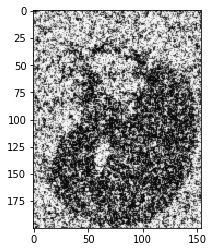

In [225]:
########### Q7 Denois and Print the obtained Image ###########
X = noisy_image_np.copy()

## Scale Input
X = X/255*2 - 1
height, width = X.shape
N = 100
np.random.seed(482)
bias = 0.5
weight = 0.3

img = getMeanImg(X, bias, weight, None, gibbsNIter=100)
plt.imshow(img, cmap="gray")
plt.savefig("figures/q7_fixedDenoising_2.png")

In [226]:
####### Print MAE of denoised image ##########

# img = Image.open('figures/q7_fixedDenoising.png').convert("L")
# imgnp = np.array(img)[44:244, :154]
# print(np.round(img))

# imgcopy = img.copy()
# imgcopy[np.where(imgcopy > 0)] = 1
# imgcopy[np.where(imgcopy < 0)] = -1
# plt.imshow(normalize(clean_image_np), cmap='gray')
# print(np.max(normalize(clean_image_np)))
# plt.savefig("figures/q7_fixedDenoising_threshold.png")

print("Mean Absolute Error for Denoised image:", error(img, normalize(clean_image_np), errtype='mae'))

Mean Absolute Error for Denoised image: 0.652546103896104


## 8 Varying Parameter Denoising

### Run Gibbs sampling Hyperparameter tuning using MSE loss - Multiple Processes

### Grid Search over values of theta_0, theta_1

In [325]:
# thetas = [x for x in itertools.product(range(3, 6), range(11, 16))]
thetas = [x for x in itertools.product(range(50, 60), range(75, 85))]

grid_precision = 100
results_q8 = Manager().dict()
args_list = []
for theta_id, theta in enumerate(thetas):
    args_list.append((X.copy(), thetas[theta_id][0]/grid_precision, thetas[theta_id][1]/grid_precision, results_q8, 100))
    

jobs = []
start = time.time()
for i in range(len(args_list)):
    p = Process(target=getMeanImg, args=args_list[i])
    jobs.append(p)
    p.start()
    
for proc in jobs:
    proc.join()
    
end = time.time()
print("Time: ", end - start)

Time:  154.68663716316223


In [361]:
pk.dump(results_q8, open('results_q8_theta1_0.3_0.6_theta2_1.1_1.6', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory

### Compute Error Metric for each configuration and sort accordingly

In [327]:
results_errs_mse = []
for theta_id, _theta in enumerate(thetas):
    theta = (_theta[0]/grid_precision, _theta[1]/grid_precision)
    err = error(results_q8[theta], normalize(clean_image_np), errtype='mse')
    results_errs_mse.append((err, theta, results_q8[theta]))
    
results_errs_mae = []
for theta_id, _theta in enumerate(thetas):
    theta = (_theta[0]/grid_precision, _theta[1]/grid_precision)
    err = error(results_q8[theta], normalize(clean_image_np), errtype='mae')
    results_errs_mae.append((err, theta, results_q8[theta]))
    
results_errs_ssim = []
for theta_id, _theta in enumerate(thetas):
    theta = (_theta[0]/grid_precision, _theta[1]/grid_precision)
    err = error(results_q8[theta], normalize(clean_image_np), errtype='ssim')
    results_errs_ssim.append((err, theta, results_q8[theta]))

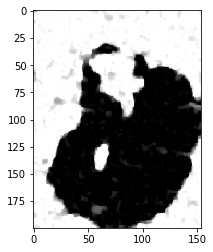

MSE:: Error: 0.002350795988107606  Theta: (0.5, 1.1)


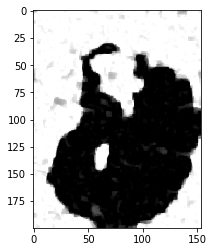

MAE:: Error: 0.1262383116883117  Theta: (0.5, 1.3)


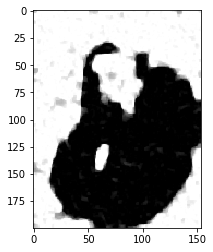

ssim:: Error: -0.6222510800964332  Theta: (0.4, 1.5)


In [343]:
#### MSE #####
results_errs_mse_sorted = sorted(results_errs_mse, key=lambda x: x[0])
plt.imshow(results_errs_mse_sorted[0][2], cmap='gray')
plt.savefig("figures/q8_varying_parameters_{}_theta1_{}_theta2_{}.png".format('mse', str(results_errs_mse_sorted[0][1][0]/10), str(results_errs_mse_sorted[0][1][1]/10)))
plt.show()
print("MSE:: Error:", results_errs_mse_sorted[0][0], " Theta:", results_errs_mse_sorted[0][1])

#### MAE #####
results_errs_mae_sorted = sorted(results_errs_mae, key=lambda x: x[0])
plt.imshow(results_errs_mae_sorted[0][2], cmap='gray')
plt.savefig("figures/q8_varying_parameters_{}_theta1_{}_theta2_{}.png".format('mae', str(results_errs_mse_sorted[0][1][0]/10), str(results_errs_mse_sorted[0][1][1]/10)))
plt.show()
print("MAE:: Error:", results_errs_mae_sorted[0][0], " Theta:", results_errs_mae_sorted[0][1])

#### SSIM #####
results_errs_ssim_sorted = sorted(results_errs_ssim, key=lambda x: x[0])
plt.imshow(results_errs_ssim_sorted[0][2], cmap='gray')
plt.savefig("figures/q8_varying_parameters_{}_theta1_{}_theta2_{}.png".format('ssim', str(results_errs_mse_sorted[0][1][0]/10), str(results_errs_mse_sorted[0][1][1]/10)))
plt.show()
print("ssim:: Error:", results_errs_ssim_sorted[0][0], " Theta:", results_errs_ssim_sorted[0][1])

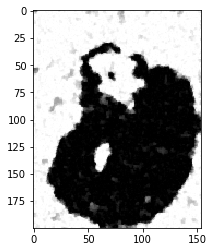

In [366]:
X = noisy_image_np.copy()

## Scale Input
X = X/255*2 - 1
height, width = X.shape
N = 100
np.random.seed(482)
bias = 0.52
weight = 0.79

img = getMeanImg(X, bias, weight, None, gibbsNIter=100)
plt.imshow(img, cmap="gray", vmin=-1, vmax=+1)
plt.savefig("figures/q8_fixedDenoising_bestparams.png")

In [368]:
print("MSE for best matching Image:", error(img, normalize(clean_image_np), errtype='mse'))

MSE for best matching Image: 0.002212512715163004


## Q9. MCMC varying wij

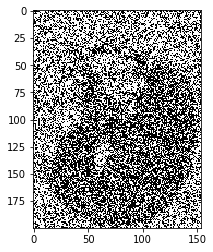

(200, 154)


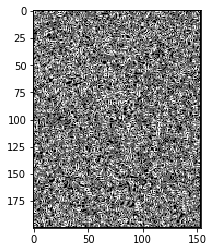

In [544]:
grad = filters.sobel(X)
plt.imshow(X, cmap='gray')
plt.show()
print(grad.shape)
plt.imshow(grad, cmap='gray')
plt.show()

In [547]:
newNeighbors = [x for x in itertools.product(range(-2, 3), range(-2, 3))]
newNeighbors.remove((0,0))
#[(0, -2), (-2, -2), (0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (0, 1), (-1, 1), (2, 2), (2, 0), (0, 2), (0, -2)]
def newW(noisyX):
    pad = 2
    neww = noisyX.copy()
    padded = np.pad(noisyX, pad)
    h, w = noisyX.shape
    for y in range(pad, h + pad):
        for x in range(pad, w + pad):
            for n in newNeighbors:
                neww[y-pad, x-pad] += padded[tuple(map(operator.add, (y,x), n))]
    neww = np.array([np.pad(neww, 1)]*4)
    return neww

def anotherW(noisyX):
    pad = 1
    neww = filters.sobel(noisyX)
    neww = np.array([np.pad(neww, pad)]*4)
    return neww

def getSamplingProbAt_q9(_grid, _bias, _weight, _width, _height, y, x):
    """
    Get Probability at x, y
    """
    neighbor_vector = np.array([_grid[tuple(map(operator.add, (y,x), t))] for t in _neighbors])
#     weight_vector = np.array([_weight[tuple(map(operator.add, (y,x), t))] for t in _neighbors])
    weight_vector = _weight
    prob = sigma(2*_bias + 2*np.sum(weight_vector*neighbor_vector))
    
    return prob

def GibbsSampling4(_grid, _Niters, _bias, _weights, _Height, _Width):
    """
    Run Niterations of gibbs sampling and generation _Niters samples
    _Niters: number of iterations to run gibbs sampling for
    _bias: Bias parameters of model
    _weights: weights for dependence on neighbors
    _Height: height of MDP grid
    _Width: width of MDP grid
    Returns a _Niters length list containing sampling generated using GibbsSampling
    """
    samples = []
    padding = 1
    gridP= np.pad(_grid, 1)
    
    yx_tuples = [t for t in itertools.product(range(1, _Height+1), range(1, _Width+1))]
    
    if (type(_weights)==float or type(_weights)==int):
        _weights = _weights*np.array([np.ones(_bias.shape)]*4)
    if (len(_weights) < 4):
        _weights = np.pad(_weights, 1)

        # yx_tuples = order_coords(yx_tuples)
    for t in range(N):
        r = np.random.uniform(0, 1, _Width*_Height)
        r = np.reshape(r, (_Width, _Height)).T

        for (y,x) in yx_tuples:
            prob = getSamplingProbAt_q9(gridP, _bias[y-1, x-1],  _weights[:, y-1, x-1], _Height, _Width, y, x)
            if (r[y-1, x-1] > prob):
                gridP[y, x] = -1
            else:
                gridP[y, x] = 1
                
        samples.append(gridP[1:-1, 1:-1].copy())
        
    return samples

In [555]:
# nw = newW(X)
nw = anotherW(X)
nwMax = np.max(nw)

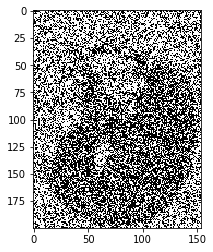

Time taken: 22.88210368156433


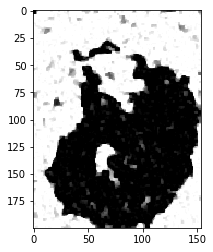

In [573]:
X = noisy_image_np.copy()
np.random.seed(482)

## Scale Input
X = X/255*2 - 1
plt.imshow((X+1)*255/2, cmap='gray')
plt.show()

bias = 0.7*X
weights = 6.7*(nwMax - 0.9*nw) #0.8*X 
height, width = X.shape
N = 50

start_time = time.time()
samples = GibbsSampling4(X, N, bias, weights, height, width)
end_time = time.time()
print("Time taken:", end_time - start_time)
plt.imshow(np.mean(samples, axis=0), cmap='gray', vmin=-1, vmax=1)
plt.savefig("q9_modw", cmap='gray')

In [574]:
print("MSE for Image:", error(np.mean(samples, axis=0), normalize(clean_image_np), errtype='mse'))
print("MAE for Image:", error(np.mean(samples, axis=0), normalize(clean_image_np), errtype='mae'))
print("MAE for Image:", error(img, normalize(clean_image_np), errtype='mae'))

MSE for Image: 0.0026760038855376087
MAE for Image: 0.15796493506493509
MAE for Image: 0.13016233766233767


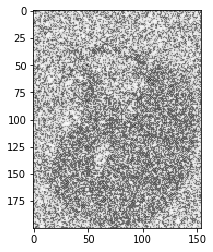

In [510]:
plt.imshow(np.mean(samples, axis=0), cmap='gray', vmin=-1, vmax=1)
plt.savefig("q9_modw", cmap='gray')

## Q10. MCMC: Faster Mixing

### Different Order for Mixing

In [484]:
###### Gibbs Sampling Update Within each iteration ########
def order_coords(all_tuples):
    ordered_tuples = sorted(all_tuples, key=lambda a: a[0] + a[1])
    return ordered_tuples

_neighbors = [(-1, 0), (0, -1), (1, 0), (0, 1)]
def gradP(_grid):
    prob = np.zeros(_grid.shape)
    indices = np.indices(_grid.shape)
    _neighbors_grid = []
    for _direction_id in range(4):
        neighbors_dir = indices.copy()
        neighbors_dir[0, 1:-1, 1:-1] = neighbors_dir[0, 1:-1, 1:-1] + _neighbors[_direction_id][0]
        neighbors_dir[1, 1:-1, 1:-1] = neighbors_dir[1, 1:-1, 1:-1] + _neighbors[_direction_id][1]
        _grid_dir = _grid[(neighbors_dir[0], neighbors_dir[1])]
        _neighbors_grid.append(_grid_dir)
    _neighbors_grid = np.array(_neighbors_grid)

    grad = np.sum(_neighbors_grid, axis=0)
    return grad

def GibbsSampling3(_grid, _Niters, _bias, _weights, _Height, _Width):
    """
    Run Niterations of gibbs sampling and generation _Niters samples
    _Niters: number of iterations to run gibbs sampling for
    _bias: Bias parameters of model
    _weights: weights for dependence on neighbors
    _Height: height of MDP grid
    _Width: width of MDP grid
    Returns a _Niters length list containing sampling generated using GibbsSampling
    """
    samples = []
    padding = 1
    gridP= np.pad(_grid, 1)
    
    yx_tuples = [t for t in itertools.product(range(1, _Height+1), range(1, _Width+1))]
    np.random.shuffle(yx_tuples)
    
    
    if (type(_weights)==float or type(_weights)==int):
        _weights = _weights*np.array([np.ones(_bias.shape)]*4)

        # yx_tuples = order_coords(yx_tuples)
    for t in range(N):
        r = np.random.uniform(0, 1, _Width*_Height)
        r = np.reshape(r, (_Width, _Height)).T
        
        gradProb = gradP(gridP)
        gradProb = gradProb[1:-1, 1:-1]
        sortingMetric = (gridP[1:-1, 1:-1]*gradProb).flatten()
        sorted_args = np.argsort(-sortingMetric)

        for arg in sorted_args:
            y = int(arg / _grid.shape[1]) + padding
            x = int(arg % _grid.shape[1]) + padding
            prob = getSamplingProbAt(gridP, _bias[y-1, x-1],  _weights[:, y-1, x-1], _Height, _Width, y, x)
            if (r[y-1, x-1] > prob):
                gridP[y, x] = -1
            else:
                gridP[y, x] = 1
                
        samples.append(gridP[1:-1, 1:-1].copy())
        
    return samples


#### Update scheme2
# visited = [False]*(_Height*_Width)
#         for arg_id in range(_Height*_Width):
#             gradProb = gradP(gridP)
#             gradProb = gradProb[1:-1, 1:-1]
#             gradProb = gradProb.flatten()    
#             arg = np.argmax(gradProb)
#             if visited[arg]:
#                 continue
#             y = int(arg / _grid.shape[1]) + padding
#             x = int(arg % _grid.shape[1]) + padding
#             prob = getSamplingProbAt(gridP, _bias[y-1, x-1],  _weights[:, y-1, x-1], _Height, _Width, y, x)
#             if (r[y-1, x-1] > prob):
#                 gridP[y, x] = -1                
#             else:
#                 gridP[y, x] = 1
#         samples.append(gridP[1:-1, 1:-1].copy())
        
#     return samples

In [449]:
def SamplesVSweightsFaster(grid, bias, weight, samplesVSweights_results_ph, MixingIters=1):
    Height, Width = grid.shape
    mixingtimeSamples = []
    for mIter in range(MixingIters):
        mixingtimeSamples.append(GibbsSampling3(grid, N, bias, weight, Height, Width))
    samplesVSweights_results_ph[weight] = np.array(mixingtimeSamples)
    return mixingtimeSamples

In [488]:
###### Run 5 Processes parallely to compute Expected performance #######
np.random.seed(482)
MixingIters_q10 = 100

grid_q10 = np.ones((30, 30))

N_q10 = 100
Height_q10 = 30
Width_q10 = 30
bias_q10 = np.zeros((Height_q10, Width_q10))

samplesVSweights_results_q10 = Manager().dict()
q10_args_list = []
for weightsIter in range(0, 6):
    weights_q10 = weightsIter/10
    q10_args_list.append((grid_q10.copy(), bias_q10, weights_q10, samplesVSweights_results_q10, MixingIters_q10))

q10_jobs = []

start = time.time()
for i in range(len(q10_args_list)):
    p = Process(target=SamplesVSweightsFaster, args=q10_args_list[i])
    q10_jobs.append(p)
    p.start()
    
for proc in q10_jobs:
    proc.join()
    
end = time.time()
print("Time: ", end - start)

Time:  218.32381439208984


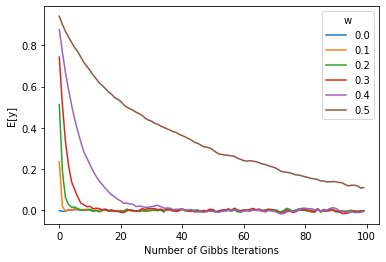

In [489]:
for _weights in range(0, 6):
    _weights_key = _weights/10
    ms = np.array(samplesVSweights_results_q10[_weights_key])
    msreshaped = np.reshape(ms, (MixingIters_q10, N_q10, ms.shape[-2]*ms.shape[-1]))
    msmean = np.mean(msreshaped, axis=2)
    msmeanmean = np.mean(msmean, axis=0)
    # plt.plot(msmeanmean)
    plt.xlabel('Number of Gibbs Iterations')
    plt.ylabel('E[y]')
    plt.plot(msmeanmean, label='_weights_key')
#     plt.errorbar(range(1,101), msmeanmean, yerr=np.var(msmean, axis=0), ecolor='orange')
    
plt.legend([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], title="w")
    
plt.savefig('figures/FastermixingTimes_w_q10_2.png')
plt.show()

## HyperParameter Tuning for individual cases

### MSE Errors for each image

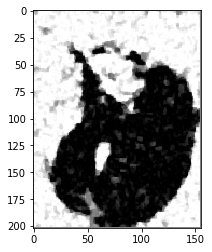

bias: 5 Weight: 10 error: 84.94704232638121


In [553]:
X = noisy_image_np.copy()

## Scale Input
X = X/255*2 - 1
height, width = X.shape
N = 100
np.random.seed(482)

err_img_mse = []
for theta0 in range(0, 11):
    bias = (theta0/10)*X
    for theta1 in range(0, 15):
        weights = (theta1/10)

        samples = GibbsSampling2(X, N, bias, weights, height, width)
        err = error( samples[-1][1:-1, 1:-1], normalize(clean_image_np), errtype='mse')
        
        mean_img = np.mean(samples, axis=0)
        err_img.append((err, mean_img, (theta0, theta1)))

err_img_sorted = sorted(err_img_mse, key=lambda x: x[0])
mm = err_img_sorted[0]
plt.imshow(mm[1], cmap="gray")
plt.savefig("figures/varying_parameters_{}_theta1_{}_theta2_{}.png".format('mse', str(theta0/10), str(theta1/10)))
plt.show()
print("bias:", mm[2][0], "Weight:", mm[2][1], "error:", mm[0])

### Run Gibbs sampling Hyperparameter tuning using MAE loss

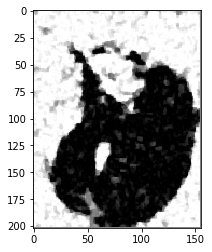

bias: 5 Weight: 10 error: 3608.0


In [555]:
X = noisy_image_np.copy()

## Scale Input
X = X/255*2 - 1
height, width = X.shape
N = 100
np.random.seed(482)

err_img_mae = []
for theta0 in range(0, 11):
    bias = (theta0/10)*X
    for theta1 in range(0, 15):
        weights = (theta1/10)

        samples = GibbsSampling(X, N, bias, weights, height, width)
        err = error( samples[-1][1:-1, 1:-1], normalize(clean_image_np), errtype='mae')        
        mean_img = np.mean(samples, axis=0)
        err_img_mae.append((err, mean_img, (theta0, theta1)))

err_img_sorted = sorted(err_img_mae, key=lambda x: x[0])
mm = err_img_sorted[0]
plt.imshow(mm[1], cmap="gray")
plt.savefig("figures/varying_parameters_{}_theta1_{}_theta2_{}.png".format('mae', str(theta0/10), str(theta1/10)))
plt.show()
print("bias:", mm[2][0], "Weight:", mm[2][1], "error:", mm[0])

### Run Gibbs sampling Hyperparameter tuning using SSIM

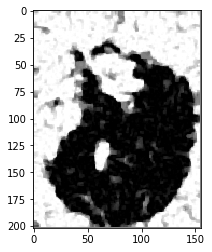

bias: 5 Weight: 13 error: -0.7263616852979774


In [556]:
X = noisy_image_np.copy()

## Scale Input
X = X/255*2 - 1
height, width = X.shape
N = 100
np.random.seed(482)

err_img_ssim = []
for theta0 in range(0, 11):
    bias = (theta0/10)*X
    for theta1 in range(0, 15):
        weights = (theta1/10)

        samples = GibbsSampling(X, N, bias, weights, height, width)
        err = error( samples[-1][1:-1, 1:-1], normalize(clean_image_np), errtype='ssim')
        
        mean_img = np.mean(samples, axis=0)
        err_img_ssim.append((err, mean_img, (theta0, theta1)))

err_img_sorted = sorted(err_img_ssim, key=lambda x: x[0])
mm = err_img_sorted[0]
plt.imshow(mm[1], cmap="gray")
plt.savefig("figures/varying_parameters_{}_theta1_{}_theta2_{}.png".format('ssim', str(theta0/10), str(theta1/10)))
plt.show()
print("bias:", mm[2][0], "Weight:", mm[2][1], "error:", mm[0])

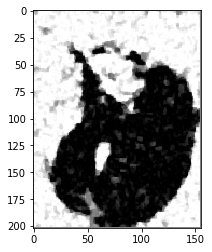

bias: 5 Weight: 10 error: 84.94704232638121


In [532]:
err_img_sorted = sorted(err_img, key=lambda x: x[0])
mm = err_img_sorted[0]
plt.imshow(mm[1], cmap="gray")
plt.savefig("figures/varying_parameters.png")
plt.show()
print("bias:", mm[2][0], "Weight:", mm[2][1], "error:", mm[0])

# for e_id in range(len(err_img_sorted)):
#     mm = err_img_sorted[e_id]
#     plt.imshow(mm[1], cmap="gray")
#     plt.show()
#     print("bias:", mm[2][0], "Weight:", mm[2][1], "error:", mm[0])

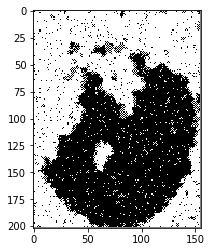

In [406]:
# err_img_sorted = sorted(err_img, key=lambda x: x[0])
# curr_min_err_img = err_img_sorted[0]
plt.imshow(curr_min_err_img[1], cmap="gray")